In [161]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import patsy
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import math

import warnings

warnings.filterwarnings("ignore")
sns.set()
sns.set_context('talk')

In [162]:
data = pd.read_csv('Seattle_Houses.csv')

In [163]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

There are a total of 19 variables and 21000+ observations included in this data set. However, there are many variables that seem to be variations of each other. For instance, view and waterfront seem to be very similar. Additionally, sqft_living15 and sqft_lot15 seem to be derived from the sqft_living and swft_lot variables. 

Just looking at the varaibles included in the data set, we hypothesize that the number of bedrooms and bathrooms, sqft_living and sqft_lot will be the most significant when predicting the housing prices. We believe these four variables are the most important because these are the most important features of a house: how big it is and how many people are able to live in the residence. Additionally, the view would be significant because from our experience, houses with a nice view tend to sell for higher prices

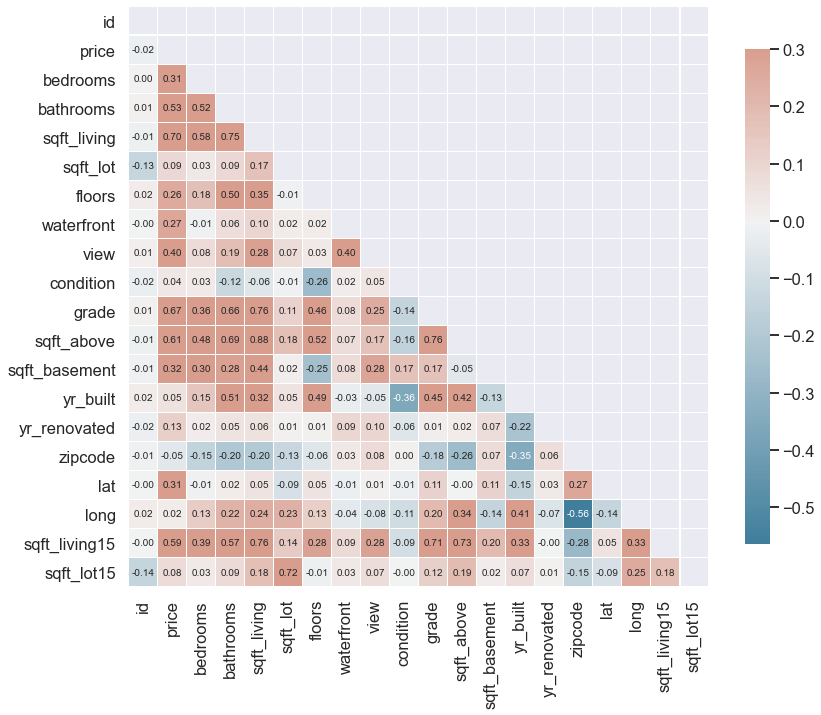

In [164]:
fig, ax = plt.subplots(figsize = (13, 13))
cmap = sns.diverging_palette(230, 20, as_cmap = True)
corr = data.corr()
mask = np.triu(np.ones_like(corr, dtype = bool))
sns.heatmap(corr, mask = mask, cmap = cmap, vmax = .3, center = 0, square = True, 
            linewidths = .5, cbar_kws = {"shrink": .7}, annot = True, fmt = '.2f', ax = ax, annot_kws = {"size": 10})

plt.savefig('corr.png', bbox_inches='tight')
plt.show()

From the correlation heatmap above, we see the top 5 features that are most correlated with price are sqft_living (0.7), grade (0.67), sqft_above(0.61), sqft_living15 (0.59), and bathrooms (0.53). 

We see sqft_living is highly correlated with sqft_living15 (0.76), sqft_above (0.88), grade (0.76), and bathrooms (0.75). We chose the threshold of multicollinearity to be 0.7, i.e if two predictors were correlated at least 0.7, then we would only choose one of the predictors. Because these five variables are highly correlated with each other (greater than our chosen threshold), if we include them all in the regression model, we will be violating the assumption of independence among the predictor variables. Hence, we choose to only include sqft_living because it is the most correlated with price among sqft_living, sqft_living15, sqft_above, grade, and bathrooms. Consequently, we need to add more predictor variables. We will be utilizing sqft_living, sqft_basement, bedrooms, lat, and view in our multiple linear regression model. 

To visualize the distributions of the predictors, we plot the sqft_living, sqft_basement, bedrooms, lat, and view predictor vairables and price, the outcome variable. 

In [165]:
def change(num):
    if num <= 0:
        return 1
    else:
        return np.log(num)
    
data['price_log'] = data['price'].apply(change)

In [176]:
data

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,price_log
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,12.309982
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,13.195614
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,770,0,1933,0,98028,47.7379,-122.233,2720,8062,12.100712
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,13.311329
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,13.142166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21608,263000018,20140521T000000,360000.0,3,2.50,1530,1131,3.0,0,0,...,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,12.793859
21609,6600060120,20150223T000000,400000.0,4,2.50,2310,5813,2.0,0,0,...,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,12.899220
21610,1523300141,20140623T000000,402101.0,2,0.75,1020,1350,2.0,0,0,...,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,12.904459
21611,291310100,20150116T000000,400000.0,3,2.50,1600,2388,2.0,0,0,...,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,12.899220


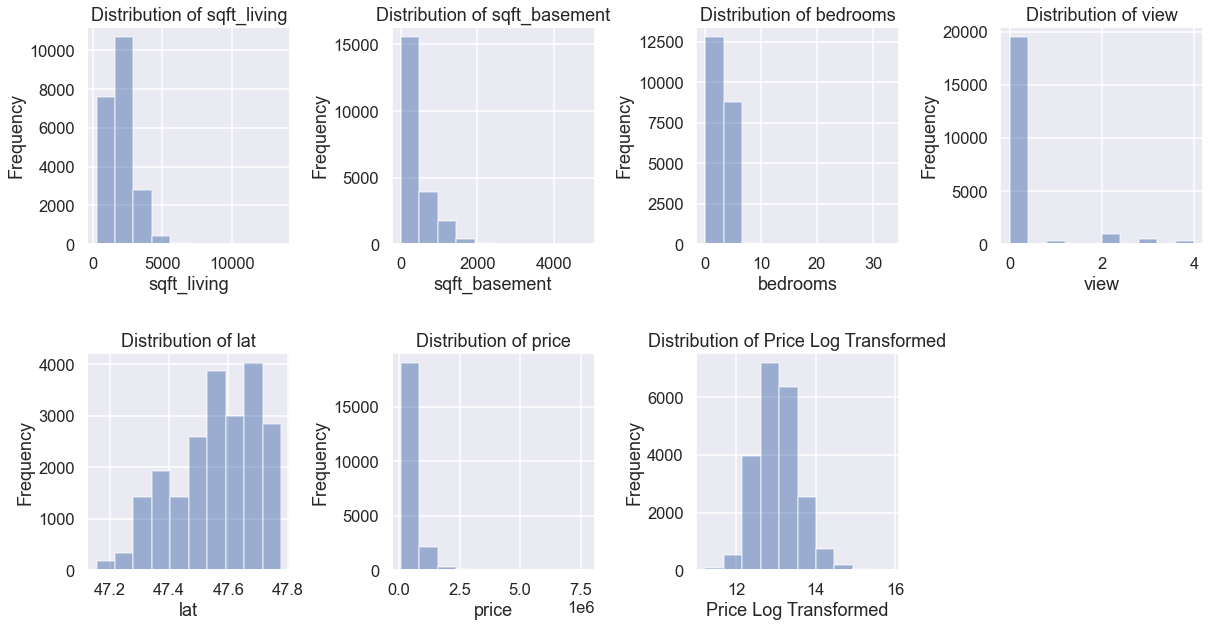

In [166]:
fig, ax = plt.subplots(2, 4, figsize = (20, 10))
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)

data['sqft_living'].plot(kind = 'hist', ax = ax[0][0], alpha = 0.5)
ax[0][0].set_title('Distribution of sqft_living')
ax[0][0].set_ylabel('Frequency')
ax[0][0].set_xlabel('sqft_living')

data['sqft_basement'].plot(kind = 'hist', ax = ax[0][1], alpha = 0.5)
ax[0][1].set_title('Distribution of sqft_basement')
ax[0][1].set_ylabel('Frequency')
ax[0][1].set_xlabel('sqft_basement')

data['bedrooms'].plot(kind = 'hist', ax = ax[0][2], alpha = 0.5)
ax[0][2].set_title('Distribution of bedrooms')
ax[0][2].set_ylabel('Frequency')
ax[0][2].set_xlabel('bedrooms')

data['view'].plot(kind = 'hist', ax = ax[0][3], alpha = 0.5)
ax[0][3].set_title('Distribution of view')
ax[0][3].set_ylabel('Frequency')
ax[0][3].set_xlabel('view')

data['lat'].plot(kind = 'hist', ax = ax[1][0], alpha = 0.5)
ax[1][0].set_title('Distribution of lat')
ax[1][0].set_ylabel('Frequency')
ax[1][0].set_xlabel('lat')

data['price'].plot(kind = 'hist', ax = ax[1][1], alpha = 0.5)
ax[1][1].set_title('Distribution of price')
ax[1][1].set_ylabel('Frequency')
ax[1][1].set_xlabel('price')

data['price_log'].plot(kind = 'hist', ax = ax[1][2], alpha = 0.5)
ax[1][2].set_title('Distribution of Price Log Transformed')
ax[1][2].set_xlabel('Price Log Transformed')
ax[1][2].set_ylabel('Frequency')

fig.delaxes(ax[1][3])

plt.savefig('distributions.png', bbox_inches='tight')
plt.show()

Above, we see the distributions of the 5 predictors plus the outcome variable. The distributions of sqft_living seems to be somewhat normal with it being skewed a little bit to the right. Additionally, for the variable of view, we see almost all of the observations in the data have a view of 0. The distribution of price, the outcome variable is extremely skewed to the right. Hence we log transform the data so that the distribution is more normal. 

Above, we see the distribution of the housing prices after log transformming the data. We see that the distribution is more normal now. 

In [177]:
temp_df = data
temp = pd.get_dummies(temp_df['view'], prefix = 'View', drop_first = True) #one hot encoding drop the default view = 0
temp_df = temp_df.join(temp)
temp_df.drop(['view'], axis = 1, inplace = True)

In [178]:
from sklearn.model_selection import KFold
kf = KFold(n_splits = 5, shuffle = True)
first = ['First Model']
second = ['Second Model']
for train, test in kf.split(temp_df):
    first_train_x = temp_df.iloc[train][['sqft_living', 'sqft_basement', 'bedrooms'] + list(temp.columns)]
    first_train_y = temp_df.iloc[train][['price_log']]
    first_test_x = temp_df.iloc[test][['sqft_living', 'sqft_basement', 'bedrooms'] + list(temp.columns)]
    first_test_y = temp_df.iloc[test][['price_log']]
    
    second_train_x = temp_df.iloc[train][['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + list(temp.columns)]
    second_train_y = temp_df.iloc[train][['price_log']]
    second_test_x = temp_df.iloc[test][['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + list(temp.columns)]
    second_test_y = temp_df.iloc[test][['price_log']]
    
    mlr1 = LinearRegression().fit(first_train_x, first_train_y)
    first_y_pred = mlr1.predict(first_test_x)
    first.append(mean_squared_error(first_test_y, first_y_pred, squared = False))
    
    mlr2 = LinearRegression().fit(second_train_x, second_train_y)
    second_y_pred = mlr2.predict(second_test_x)
    second.append(mean_squared_error(second_test_y, second_y_pred, squared = False))
    
first = [first[0]] + [round(i, 5) for i in first[1:]]
second = [second[0]] + [round(i, 5) for i in second[1:]]

In [179]:
kf_df = pd.DataFrame([first, second], columns = ['Model', 'First Iteration', 'Second Iteration', \
                                                    'Third Iteration', 'Fourth Iteration', 'Fifth Iteration'])
kf_df.set_index(['Model'], inplace = True)
kf_df['Mean RMSE'] = kf_df.mean(axis = 1)
kf_df.to_csv('kf_df.csv', index = True)
kf_df

,First Iteration,Second Iteration,Third Iteration,Fourth Iteration,Fifth Iteration,Mean RMSE
Model,,,,,,
First Model,0.36964,0.37172,0.36364,0.37193,0.36245,0.367876
Second Model,0.29917,0.30202,0.29015,0.29723,0.29112,0.295938


In [180]:
train, test = train_test_split(temp_df, test_size = 0.2)

In [181]:
x_train = train[['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + list(temp.columns)]
y_train = train[['price_log']]

x_test = test[['sqft_living', 'sqft_basement', 'bedrooms', 'lat'] + list(temp.columns)]
y_test = test[['price_log']]

In [182]:
outcome, predictors = patsy.dmatrices('price_log ~ View_1 + View_2 + View_3 + View_4 + sqft_living + sqft_basement + bedrooms + lat', data = train)
mod = sm.OLS(outcome, predictors).fit()
print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:              price_log   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.682
Method:                 Least Squares   F-statistic:                     4639.
Date:                Thu, 15 Jul 2021   Prob (F-statistic):               0.00
Time:                        12:31:31   Log-Likelihood:                -3496.8
No. Observations:               17290   AIC:                             7012.
Df Residuals:                   17281   BIC:                             7082.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -63.3103      0.782    -80.979

In [191]:
inter = ['Intercept', round(mod.params[0], 3), round(mod.bse[0], 3), 
         round(mod.tvalues[0], 3), round(mod.pvalues[0], 5), str(np.round(mod.conf_int(alpha=0.05)[0], 3))]
view1 = ['View = 1', round(mod.params[1], 3), round(mod.bse[1], 3), 
         round(mod.tvalues[1], 3), round(mod.pvalues[1], 5), str(np.round(mod.conf_int(alpha=0.05)[1], 3))]
view2 = ['View = 2', round(mod.params[2], 3), round(mod.bse[2], 3), 
         round(mod.tvalues[2], 3), round(mod.pvalues[2], 5), str(np.round(mod.conf_int(alpha=0.05)[2], 3))]
view3 = ['View = 3', round(mod.params[3], 3), round(mod.bse[3], 3), 
         round(mod.tvalues[3], 3), round(mod.pvalues[3], 5), str(np.round(mod.conf_int(alpha=0.05)[3], 3))]
view4 = ['View = 4', round(mod.params[4], 3), round(mod.bse[4], 3), 
         round(mod.tvalues[4], 3), round(mod.pvalues[4], 5), str(np.round(mod.conf_int(alpha=0.05)[4], 3))]
living = ['sqft_living', "{:.2e}".format(mod.params[5]), "{:.2e}".format(mod.bse[5]), 
         round(mod.tvalues[5], 3), round(mod.pvalues[5], 5), str(np.round(mod.conf_int(alpha=0.05)[5], 3))]
basement = ['sqft_basement', "{:.2e}".format(mod.params[6]), "{:.2e}".format(mod.bse[6]), 
         round(mod.tvalues[6], 3), round(mod.pvalues[6], 5), str(np.round(mod.conf_int(alpha=0.05)[7], 3))]
bed = ['bedrooms', round(mod.params[7], 3), round(mod.bse[7], 3), 
         round(mod.tvalues[7], 3), round(mod.pvalues[7], 5), str(np.round(mod.conf_int(alpha=0.05)[8], 3))]
lat = ['lat', round(mod.params[8], 3), round(mod.bse[8], 3), 
         round(mod.tvalues[8], 3), round(mod.pvalues[8], 5), str(np.round(mod.conf_int(alpha=0.05)[8], 3))]

df = pd.DataFrame([inter, view1, view2, view3, view4, living, basement, bed, lat], 
                  columns = ['Parameters', 'Coefficients', 'Standard Error', \
                             'T-Statistics', 'P-Values', '95% Confidence Interval'])

df.set_index('Parameters', inplace = True)
print('Adjusted R-Squared: ' + str(round(mod.rsquared, 5)))
df.to_csv('coef.csv', index = True)
df

Adjusted R-Squared: 0.68229


,Coefficients,Standard Error,T-Statistics,P-Values,95% Confidence Interval
Parameters,,,,,
Intercept,-63.31,0.782,-80.979,0.0,[-64.843 -61.778]
View = 1,0.255,0.019,13.710,0.0,[0.219 0.292]
View = 2,0.224,0.011,20.209,0.0,[0.203 0.246]
View = 3,0.31,0.015,20.431,0.0,[0.28 0.34]
View = 4,0.527,0.019,27.334,0.0,[0.489 0.565]
sqft_living,3.83e-04,3.27e-06,116.969,0.0,[0. 0.]
sqft_basement,-7.12e-05,5.85e-06,-12.171,0.0,[-0.025 -0.013]
bedrooms,-0.019,0.003,-6.404,0.0,[1.558 1.622]
lat,1.59,0.016,96.745,0.0,[1.558 1.622]


In [187]:
"{:.2e}".format(mod.params[5])

'3.83e-04'

From the model we had fitted above, we see all of the predictor variables were significant. Each predictor variable had a p-value very close to 0 (shown as 0 due to rounding), less than the threshold of $\alpha = 0.05$. Additionally, looking at the T-Statistic values, we see the predictor of sqft_living is the most significant with a value of $113.061$. 

In our model, because we had multiple predictors, we look at the adjusted R-squared for information regarding how much of the data's variance is actually explained by our model. We see the adjusted r-squared value is $0.6247 = 62.47\%$. This leads us to conclude that our model only explains around half of the data's variance and may not do a good job in predicting house prices in Seattle. 

Proceeding with the prediction, we utilize the Linear Regression package from sklearn. As for training and testing, we use an 80/20 split, 80% of the data (around 16800) is used for training while 20% of the data (around 4200) is used for testing. 

In [174]:
mlr = LinearRegression().fit(x_train, y_train)
y_pred = mlr.predict(x_test)

mean_squared_error(y_test, y_pred, squared = False)

0.2948360175887784

After predicting the log transformation of the price, we obtain a root mean squared error or $0.2963$

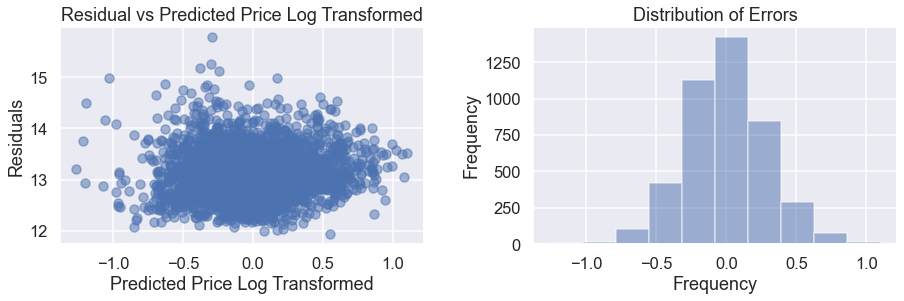

In [175]:
fig, ax = plt.subplots(1, 2, figsize = (15, 4))
plt.subplots_adjust(wspace = 0.3)

residuals = np.array(y_test['price_log']) - y_pred.flatten()
ax[0].scatter(residuals, y_pred, alpha = 0.5)
ax[0].set_title('Residual vs Predicted Price Log Transformed')
ax[0].set_xlabel('Predicted Price Log Transformed')
ax[0].set_ylabel('Residuals')

pd.Series(residuals).plot(kind = 'hist', alpha = 0.5, ax = ax[1])
ax[1].set_title('Distribution of Errors')
ax[1].set_xlabel('Errors')
ax[1].set_xlabel('Frequency')

plt.savefig('errors.png', bbox_inches='tight')
plt.show()